# Credit Card Fraud Detection - Thresholding & PR Curves

## The purpose of this notebook: 
With extreme class imbalance, the default threshold (0.50) is rarely optimal. In this notebook we will: 
1) Fit a probability model 
2) Use **out-of-fold** predictions to pick a decision threshold 
3) Evaluate that chosen threshold on the test set 

In [1]:
# Imports 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    confusion_matrix,  
    classification_report, 
    precision_recall_curve, 
    average_precision_score, 
    roc_auc_score, 
) 
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import RobustScaler 
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

## 1) Load Data & Split Train/Test

Similar to the last notebook, we stratify to preserve the fraud rate in the train and test sets 

In [2]:
DATA_PATH = "../data/raw/creditcard.csv" 
df = pd.read_csv(DATA_PATH) 

X = df.drop(columns=["Class"]) 
y = df["Class"] 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y 
)

print("Train fraud rate:", y_train.mean()) 
print("Test fraud rate:", y_test.mean()) 

Train fraud rate: 0.001729245759178389
Test fraud rate: 0.0017204452090867595


## 2) Preprocessing 

The main transaction features (V1,...,V28) are already pretty normalized. 

`Time` and `Amount` would benefit most from scaling. 

In [3]:
scale_cols = ["Time", "Amount"] 
pass_cols = [c for c in X.columns if c not in scale_cols] 

preprocess = ColumnTransformer(
    transformers=[
        ("scale", RobustScaler(), scale_cols), 
        ("pass", "passthrough", pass_cols), 
    ], 
    remainder="drop",
)

## 3) Model: Logistic Regression 

We'll start with a strong baseline using logistic regression with a balanced `class_weight` so it is more cost-sensitive towards the fraud, taking into account the imbalanced dataset. 

In [4]:
model = Pipeline(steps=[
    ("preprocess", preprocess), 
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced", 
        solver="liblinear"
    ))
])

##  4) Out-of-fold Probability Predictions 

We will choose the decision threshold using *only training data* via cross-validation 

This avoids using the test set to make modelling decisions. 

In [5]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 

oof_proba = cross_val_predict(
    model, X_train, y_train, 
    cv=cv, 
    method="predict_proba"
)[:, 1] 

print("OOF PR-AUC:", average_precision_score(y_train, oof_proba))
print("OOF ROC-AUC:", roc_auc_score(y_train, oof_proba)) 

OOF PR-AUC: 0.7408884871140407
OOF ROC-AUC: 0.9815489907381624


## 5) Precision–Recall Curve & Threshold Selection
We'll visualize the PR curve, then pick a threshold using one of the following:
- Maximizing the F1 score
- Satisfy a minimum recall target (often preferred for fraud)

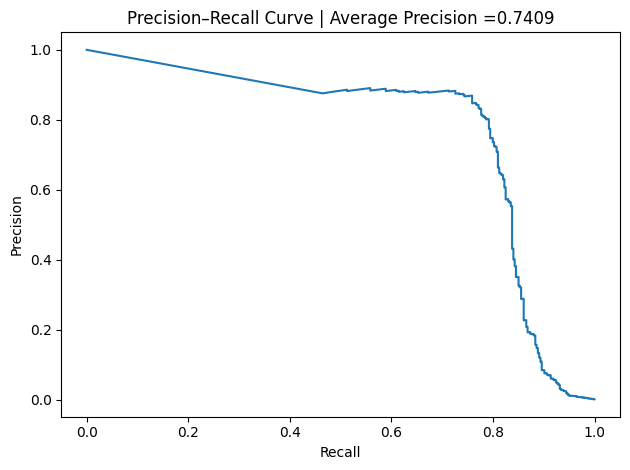

In [6]:
prec, rec, thresh = precision_recall_curve(y_train, oof_proba)
ap = average_precision_score(y_train, oof_proba)

plt.plot(rec, prec)
plt.title(f"Precision–Recall Curve | Average Precision ={ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.tight_layout()
plt.show()

In [7]:
# Some threshold picking utility functions 
def threshold_table(y_true, proba, thresholds):
    rows = []
    for t in thresholds:
        pred = (proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
        precision = tp / (tp + fp) if (tp + fp) else 0.0
        recall = tp / (tp + fn) if (tp + fn) else 0.0
        f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) else 0.0
        rows.append((t, precision, recall, f1, fp, fn))
    return pd.DataFrame(rows, columns=["threshold","precision","recall","f1","fp","fn"])

grid = np.linspace(0.01, 0.99, 99)
tbl = threshold_table(y_train.values, oof_proba, grid)
tbl.sort_values("f1", ascending=False).head(10)

,threshold,precision,recall,f1,fp,fn
98,0.99,0.604089,0.824873,0.697425,213,69
97,0.98,0.552764,0.837563,0.665994,267,64
96,0.97,0.478955,0.837563,0.609418,359,64
95,0.96,0.418987,0.840102,0.559122,459,63
94,0.95,0.373318,0.845178,0.517885,559,61
93,0.94,0.338384,0.850254,0.484104,655,59
92,0.93,0.310599,0.855330,0.455713,748,57
91,0.92,0.287045,0.860406,0.430476,842,55
90,0.91,0.264224,0.860406,0.404293,944,55
89,0.90,0.248534,0.860406,0.385666,1025,55


### Choosing a threshold
Option A: Maximize F1 on OOF

Option B: Enforce recall >= target (e.g., 0.85), then choose best precision among those

In [8]:
best_f1_row = tbl.sort_values("f1", ascending=False).iloc[0]
best_f1_threshold = float(best_f1_row["threshold"])
print("Best-F1 Threshold:", best_f1_threshold, "\n", best_f1_row)

# Example recall target approach:
recall_target = 0.85
candidates = tbl[tbl["recall"] >= recall_target].sort_values("precision", ascending=False)

if len(candidates) > 0:
    best_recall_threshold = float(candidates.iloc[0]["threshold"])
    print("\nRecall-target threshold:", best_recall_threshold)
    print(candidates.head(5))
else:
    best_recall_threshold = best_f1_threshold
    print("\nNo threshold hit recall target; fallback to best F1 threshold.")

Best-F1 Threshold: 0.99 
 threshold      0.990000
precision      0.604089
recall         0.824873
f1             0.697425
fp           213.000000
fn            69.000000
Name: 98, dtype: float64

Recall-target threshold: 0.9400000000000001
    threshold  precision    recall        f1    fp  fn
93       0.94   0.338384  0.850254  0.484104   655  59
92       0.93   0.310599  0.855330  0.455713   748  57
91       0.92   0.287045  0.860406  0.430476   842  55
90       0.91   0.264224  0.860406  0.404293   944  55
89       0.90   0.248534  0.860406  0.385666  1025  55


## 6) Final Evaluation 
We now refit on the full training set and evaluate on test using the chosen threshold.

In [13]:
chosen_threshold = best_f1_threshold  

model.fit(X_train, y_train)
test_proba = model.predict_proba(X_test)[:, 1]
test_pred = (test_proba >= chosen_threshold).astype(int)

print("Test ROC-AUC:", roc_auc_score(y_test, test_proba))
print("Test PR-AUC:", average_precision_score(y_test, test_proba))
print("\nConfusion matrix:\n", confusion_matrix(y_test, test_pred))
print("\nReport:\n", classification_report(y_test, test_pred, digits=4))

Test ROC-AUC: 0.9720996498627588
Test PR-AUC: 0.7189400803258542

Confusion matrix:
 [[56802    62]
 [   15    83]]

Report:
               precision    recall  f1-score   support

           0     0.9997    0.9989    0.9993     56864
           1     0.5724    0.8469    0.6831        98

    accuracy                         0.9986     56962
   macro avg     0.7861    0.9229    0.8412     56962
weighted avg     0.9990    0.9986    0.9988     56962



In [14]:
chosen_threshold = best_recall_threshold 

model.fit(X_train, y_train)
test_proba = model.predict_proba(X_test)[:, 1]
test_pred = (test_proba >= chosen_threshold).astype(int)

print("Test ROC-AUC:", roc_auc_score(y_test, test_proba))
print("Test PR-AUC:", average_precision_score(y_test, test_proba))
print("\nConfusion matrix:\n", confusion_matrix(y_test, test_pred))
print("\nReport:\n", classification_report(y_test, test_pred, digits=4))

Test ROC-AUC: 0.9720996498627588
Test PR-AUC: 0.7189400803258542

Confusion matrix:
 [[56701   163]
 [   11    87]]

Report:
               precision    recall  f1-score   support

           0     0.9998    0.9971    0.9985     56864
           1     0.3480    0.8878    0.5000        98

    accuracy                         0.9969     56962
   macro avg     0.6739    0.9424    0.7492     56962
weighted avg     0.9987    0.9969    0.9976     56962



In the next notebook we'll look to add SMOTE pipelines, XGBoost, and then compare everything. 